<a href="https://colab.research.google.com/github/richardOlson/nfl_2019_play_by_play/blob/master/nfl_plays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install pandas-profiling==2.*

In [0]:
%%capture
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import plotly.express as px


In [0]:
df19 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play2019.csv')

In [0]:
df17 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play_2017.csv')

In [0]:
df18 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play_2018.csv')

In [0]:
df16 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play_2016.csv')

In [0]:
df16.shape , df17.shape, df18.shape, df19.shape

((45951, 45), (45293, 45), (45016, 45), (42186, 45))

In [0]:
d18 = df18.copy()
d19 = df19.copy()
d17 = df17.copy()
d16 = df16.copy()

In [0]:
# Seeing what the values for the playTypes are
df18['PlayType'].value_counts(dropna=False)

PASS                    18492
RUSH                    12173
KICK OFF                 2645
PUNT                     2295
TIMEOUT                  1866
NaN                      1560
SACK                     1370
EXTRA POINT              1229
FIELD GOAL                948
NO PLAY                   829
SCRAMBLE                  826
QB KNEEL                  393
TWO-POINT CONVERSION      134
EXCEPTION                  91
FUMBLES                    85
CLOCK STOP                 78
PENALTY                     2
Name: PlayType, dtype: int64

In [0]:
# making a function that will make a new feature called "complete_time"
# complete time will put the minute and the second together to make a float of min.sec
def combineMinSec(row):
  theMin = row['Minute']
  theSec = row['Second']/100
  return theMin + theSec



# Separating the plays by game id.
# making the function that will separte the dataFrame by games
# A  list is returned that has the dataframe divided up by game
def separateToGameId(dataFrame):
# first getting the unique values for game id
# Unique will return an numpy array
  unique_games = dataFrame['GameId'].unique()
# Building a list of dataFrame of unique games
  games = [dataFrame[dataFrame['GameId'] == x] for x in unique_games]
  
  return  games



# inner method to find the start and the end of range for each 
# quarter
def findQuarterRange(theGame, whichQuarter):
  '''
  Will return a tuple with the start and the end 
  of each quarter and if has reached the end
  If the third value in the tuple is set to true use to the end for the 
  slice object. Tuple is as is: (start, end, boolean--reachedEnd)
  '''
  theStart = 0
  theEnd = 0
  hasStart = False 
  foundEnd = False
  reachedEnd = False
  for i in range(len(theGame['Quarter'].index)):
    row =  theGame.iloc[i]
    if hasStart == False:
      
      if row['Quarter'] == whichQuarter:
        theStart = i
        hasStart = True

    elif row['Quarter'] != whichQuarter:
      theEnd  = i
      foundEnd = True
      break
    if foundEnd == False and i == (len(theGame.index) - 1):
      theEnd = i
      reachedEnd = True
  return theStart, theEnd, reachedEnd



# Function that will do the join operation on the quarters to make a complete game
def buildGame(quartersList):
   
  for i in range(len(quartersList)):
    if i == 0:
      first = quartersList[i]
      second = quartersList[i+1]
      completeGame = pd.concat([first, second], ignore_index=True)
    if i == 1:
      continue
    else:
      completeGame = pd.concat([completeGame, quartersList[i]], ignore_index=True)
  return  completeGame






# Sorting the rows that have been sortet by quarter by time
def sortByTime(gamesList):
  ''' This method will sort the games by time by finding the object 
      slice for each quarter present in the game.
      Time is sorted in a descending fashion same as how it is in a game.

      Returns the list of games that was passed in as a parameter
  '''
  
  # this list that will be returned as the games in a list(now sorted)
  gamesSorted = []
  
  for i in range(len(gamesList)):
    # getting a list to put the sorted dataFrame into these are the quarters 
    # that are sorted.
    quarters = []
    # for loop for amount of  different quarters
    for j in range(len(gamesList[i]['Quarter'].value_counts().index.to_list())):
      # Getting the start and the stop of the slice
      theStart, theEnd, reachedEnd = findQuarterRange(gamesList[i], j + 1)
      if reachedEnd:
        quarters.append(gamesList[i].iloc[theStart:].sort_values('Time', ascending=False)) 
      else:
        quarters.append(gamesList[i].iloc[theStart:theEnd].sort_values('Time', ascending=False))
    # building each game back up
    theGame = buildGame(quarters)
    gamesSorted.append(theGame)
    # TODO need to make the function that will build the game dataframes
  return gamesSorted
  

#------------------------------------------------------------------------
            # Score making functions

# making the score

# Function for checking if there is a touchDown
# It will return a number if there really was no touchdown
# If there is a touchdown then it will return the team who scored the touchdown

def whoScored(df, i, row_description):
  theCounter = i+1
  numberOfSearches = 1
  secondaryCount = i +1
  playReversed = row_description.rfind("PLAY WAS REVERSED")
  touchDown = row_description.rfind('TOUCHDOWN')
  time_touchdown_occured = df.iloc[i]['SecondsLeftInGame']
  extraPointTime = 0
  # Looking at the end of the game or the the end of the half
  endHalf = time_touchdown_occured < 1800 and time_touchdown_occured > 179
  if i >= len(df) -3:
    for j in range(i, len(df)):
      if (df.iloc[j]['PlayType'] == 'KICK OFF' or df.iloc[j]['IsTwoPointConversion'] == 1 
          or df.iloc[j]["PlayType"] == 'EXTRA POINT'):
        
        return df.iloc[j]['OffenseTeam']
    # if the following if statement is false that means that there was no 
    # touchdown. Some penalty caused it to be called back.
    if touchDown > playReversed:
      return df.iloc[i]['OffenseTeam']
    else:
      return theCounter
  # This means that the play was reversed
  if touchDown > playReversed:
    # If in here will be looking to see what team it is that has scored
    for num in range(i+1,i+4,1):
      # Adding this to stop from going out of the index
      if i == len(df)-4:
        num -=1
      #if numberOfSearches <= 3:
      if (df.iloc[num]['PlayType'] == 'EXTRA POINT' or df.iloc[num]['IsTwoPointConversion'] == 1): 
        # Setting the time that the extra point or two point conversion happened
        extraPointTime = df.iloc[num]['SecondsLeftInGame']
         # Choosing the stop point for the loop in searching for the
        # kickoff.  Making sure index isn't out of bounds
        stopPoint = i+10 if 10 < (len(df) - i) else len(df)
        for j in range(i+1, stopPoint, 1):
          #Now searching for a kickoff to see if they will match to
          #the Extra Point or two Point conversion 
          #Find the team that scored
          if df.iloc[j]['PlayType']  == "KICK OFF" and df.iloc[j]['SecondsLeftInGame'] == extraPointTime:
            return df.iloc[j]['OffenseTeam']
      # incrementing the counter
      theCounter +=1
      numberOfSearches +=1

  # Will check to see if the extra point and the kick off happened same time 
  # The time ordering can put it in front of the touchdown
  
    for j in range(i-1, i-3, -1):
      # This is a boolean to see if they occured the same time
      kick_or_two_point_time = time_touchdown_occured == df.iloc[j]['SecondsLeftInGame']
      if kick_or_two_point_time == True and df.iloc[j]['PlayType'] == "KICK OFF":
        return df.iloc[j]['OffenseTeam']
      elif kick_or_two_point_time == True and df.iloc[j]['PlayType'] == "EXTRA POINT":
        return df.iloc[j]['OffenseTeam']
      elif kick_or_two_point_time == True and df.iloc[j]['IsTwoPointConversion'] == 1:
        return df.iloc[j]['OffenseTeam']

      #df.iloc[secondaryCount]['PlayType'] == 'EXTRA POINT':
      #  secondaryCount +=1
      #  return df.iloc[i+1]["OffenseTeam"]
    
      
      # will return the counter if there was a penalty
  return theCounter
    


# This method will return a list that contains the scores
# in the football game but as one integer.
#  The number is representative of the offenseTeam.  0 means tie.
# 7 means the offense team is 7 points ahead.  -7 means the offense team is 
# 7 points behind.
def createScore(df):
  # This is the list that will keep the score 
  score = [0]
  # This the the first team
  trow = df.iloc[0]
  team = ''
  teamScored = ''
  newScore = 0

  for i in range(len(df)):
    # get the current team
    team = df.iloc[i]['OffenseTeam']

    if i == (len(df) -1):
      # Don't want to do anything to the score if it is the
      # last play of the game.
      #newScore = score[i]
      return score

    row = df.iloc[i]
    row_description = row['Description']
    nextPlay = df.iloc[i + 1]

    # TouchDown
    if row['IsTouchdown'] == 1:

      scoringTeam = whoScored(df, i, row_description)
      # This would mean that no one scored
      if isinstance(scoringTeam, int):
        if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
        else:
          newScore = score[i] + 0
      # Checking to see who scored the touchDown
      # making the score a negative
      elif team !=  nextPlay['OffenseTeam'] :
        if scoringTeam != team:
          newScore  = (score[i] - 6) * -1 
        else:
          newScore = ((score[i] + 6) *-1)
        
                   
      else:
    
        if scoringTeam != team:
          newScore = score[i] -6  
        else:       
          newScore = (score[i] + 6)
        
        
        # adding the new score to the list
      score.append(newScore)
       # Checking for an extra point  
        
    elif row['PlayType'] == "EXTRA POINT" :
      
      if row_description.find('IS GOOD') != -1:
        if nextPlay['OffenseTeam'] != team:
          newScore = ((score[i] + 1) * - 1)
        else:
          newScore = score[i] + 1
          # if it was missed
      elif nextPlay['OffenseTeam'] != team:
        newScore = (score[i] * -1)
      else:
        newScore = score[i] + 0
      score.append(newScore)

    # Field Goals    
    elif  row['PlayType'] == 'FIELD GOAL':
      # This is the team that has kicked the field goal
      
      if row_description.find('IS GOOD') != -1:
        
        if nextPlay['OffenseTeam'] == team:
          newScore = score[i] + 3
        else:
          newScore = ((score[i] + 3) * -1)
      # if the field goal was missed and no TouchDown
      else:
        if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
        else:
          newScore = score[i] + 0
      score.append(newScore)
    # Doing two point conversions
    elif row['IsTwoPointConversion'] == 1:
      if row['IsTwoPointConversionSuccessful'] == 1:
        
        if nextPlay['OffenseTeam'] == team:
          newScore = (score[i] + 2)
        else:
          newScore = ((score[i] + 2) * -1)
          
      else:  # Tried the two Point conversion, not succesfull
        # will check to see if there was a defensive two point 
        # conversion
        two =  row_description.find('DEFENSIVE TWO-POINT ATTEMPT') 
        if two != -1 and two > row_description.find('ATTEMPT FAILS'):
          # defense scored
          if nextPlay['OffenseTeam'] == team:
            newScore = score[i] -2
          else:
            newScore = (score[i] -2) * -1
        elif nextPlay['OffenseTeam'] == team:
          newScore = score[i]
        else:
          newScore = (score[i] * -1)
      
       # Putting the newscore in the list 
      score.append(newScore)

    # Doing safties
    
    elif row_description.find('SAFETY') != -1:
      # Checking if the next play is a kickoff by same
      
      if nextPlay['OffenseTeam'] == team:
        # Using i - 2 because the team who is the offense has
        # not changed yet because they now have to kick the ball and are considered
        # offense still but the defense scored so it is negative
        newScore = score[i] - 2
      else:
        newScore = ((score[i] - 2) * -1)
      score.append(newScore)
    
    # Deciding what to do on all other plays
    else:
         
        # Other Team has the ball
      if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
      else:
        newScore = score[i]
      # appending the newScore
      score.append(newScore)

        
        


              # End of Score making functions
#---------------------------------------------------------------------------------



        


# Separating the each game by the teams when on offense and then reordering
# with the secondsTillgame column.
# This method will return a list that has 
# the games divided by each team
def separateByTeam(games):
  firstTeam = ''
  secondTeam = ''
  newGamesList = []
  for game in games:
    firstTeam = game.iloc[0]['OffenseTeam']
    for i in range(len(game)):
      if game.iloc[i]["OffenseTeam"] != firstTeam:
        secondTeam = game.iloc[i]["OffenseTeam"]
        break
    # Separating each game by each team when they are
    # on offense
    first = game[game['OffenseTeam'] == firstTeam]
    second = game[game['OffenseTeam'] == secondTeam]
    newGamesList.append(first)
    newGamesList.append(second) 
  # returning the list that contains the games broken down by team 
  # when they are on offense
  return newGamesList  





# Creating a method to make the seconds till end of game
def makeSecondsTillEnd(df):
  # make a list
  secondsList = []

  for i in range(len(df.index)):
    
    row = df.iloc[i]
    if row['Quarter'] == 5:
      ans = (row['Minute'] * 60) + row['Second']
      # Overtime is for only 10 minutes
      ans = ((600 - ans) * -1)
      secondsList.append(ans)
    else:
      ans = ((4 - row['Quarter'] )* 900) + (row['Minute'] * 60) + row['Second']
      secondsList.append(ans)
  return secondsList
  



# We will now make the target feature
# I want a name and not one or zero or True or False
def makeTarget(df):
  #df = df.copy()
  mask = (df['IsRush'] == 1)
  theList = []
  for i in range(len(df)):
    if mask.iloc[i] == 1:
      theList.append('Rush')
    else:
      theList.append('Pass')
      
  df['Play'] = theList
  
   
  return df




# making columns for each down
# Trying to see if this will make model see the importance of the down that it is on
# This method will drop the toGo and the down features
def makeDownCols(df):
  first = []
  second = []
  third = []
  fourth = []
  twoPoint = []
  for i in range(len(df)):
    if df.iloc[i]['Down'] == 1:
      first.append(df.iloc[i]['ToGo'])
      second.append(0)
      third.append(0)
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 2:
      first.append(0)
      second.append(df.iloc[i]['ToGo'])
      third.append(0)
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 3:
      first.append(0)
      second.append(0)
      third.append(df.iloc[i]['ToGo'])
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 4:
      first.append(0)
      second.append(0)
      third.append(0)
      fourth.append(df.iloc[i]['ToGo'])
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 0:
      first.append(0)
      second.append(0)
      third.append(0)
      fourth.append(0)
      twoPoint.append(df.iloc[i]['ToGo'])
      
  

  df['first_to_go'] = first
  df['second_to_go'] = second
  df['third_to_go'] = third
  df['fourth_to_go'] = fourth
  df['two_point_to_go'] = twoPoint
    
  return df



#----------------------------------------------------------------
      # Functions for making the prev play categories
# creating the function that will categorize
# how succesfull a play is.
# Folowing what was determined by 
# Bob Carroll and Pete Palmer and John Thorn, in their
# book called "The Hidden Game of Football".
# Also using a method similar to those on Footballoutsiders.com

# First Down play need --- 45% of required yards (yards for first down)to get a point
# Second Down play needs-- 60% of required yards (yards for first down)
# Third and Forth need 100 % of required yards to first down to be succes

def getPercentage(down, distance):
  
  if down == 4 or down == 3:
    return distance
  if down == 2:
    return distance * .6
  if down == 1:
    return distance * .45 
    # returning this if for some reason a down is 0
  if down == 0:
    return 1

# This is an inner method that will load the 
# categories with the score
# I am using this method instead of a pandas cut 
# because I already am looping through
# the dataframe to get the score so at the
# same time will make the categories
def fillOtherCat(numberToSkip, catList):
  for i in range(len(catList)):
    if numberToSkip != i:
      catList[i].append(0)
  return catList

def loadCategories(catList, score, theBins):

  # will only loop to be able to put in each category
  for i in range(len(theBins)):
    # if the score is greater than upper bin
    # the the score must be placed in a lower bin
    if score < theBins[i]:
      catList[i].append(1)
      catList = fillOtherCat(i, catList)
      return  catList


# Succesfull play == 1 point 
# Unsuccesfull play = 0 points
# Fractional points for can by if yards are gained but not the complete
# required for the down
# First Fractional (yardsGained/YardsNeededFor45%ToFirstDown - ( .1)
# Second Fraction  (yardsGained/YardsNededFor60%ToFirstDown) -(.2)
# Third Fraction (yardsGained/YardsNeededToFirstDown) - .3
# Fourth Fraction --No Fraction if not succesfull

# Fumble == minus 2
# Interception == minus 4
# loss of 3 yards or more minus 1 point

# Got a TouchDown plus  1 point 
# Gained 15 yards 1 point
# If got a first down on a fourth down get an extra point

# Categories:
# High Success = 2 points
# Sucessfull = 1 points up to 2
# SomeWhatSucessfull =  .5 to.99
# MildlySuccesfull = greater than .25 to less than .50
# VeryLittleSucess = greater then .20 to .25
# Unsuccesfull = 0 points to .19
# BadPlay = less than 0



def createSuccesCategories(df,  asScore=False , addCatAsColumns=True):
  ''' Method to make the categories for the type of previous play

      df: The dataframe that to be worked on.

      asScore:  Default is False.  When true will cause the scores used to 
                bin the previous plays to be returned as a list.

      addCatAsColumns:  Default is True. When True it will cause the categories
                        to be added to the dataFrame and then the whole dataFrame is 
                        returned. When false will return a list that contains the categories
                        The first category is the worst and progressively getting better
                        and better to the end of the category list.
      
      Returns:    Will return list of Scores is asScore is True.  Will return list of 
                  categorieys if addCatAsColumns is False.  Otherwise will return the new
                  dataframe with the categories added to it.
                  '''
                 
  # Creating the lists that will make the categories 
  highSuccess = []
  success = []
  somewhat = []
  mildSuccess = []
  littleSuccess = []
  unsucces = []
  bad = []

  # This is the default score for the first play
  defaultScore = .65
  playQuality = [defaultScore] # This is appended because we are looking at
                      # the previous play.  The first play recieves this
                      # score for a pretend previou play neither success nor
                      # to much success.  
  score = 0
  theScore = 0
  bins = [0, .20, .26, .51, 1.0, 2, 99]

  catNames =   [ 'prev_ply_bad','prev_ply_no_succ', 'prev_ply_little_succ',
              'prev_ply_mild_succ', 'prev_ply_somewhat_succ', 'prev_ply_succ',
              'prev_ply_high_succ'
              ]

  # Loading all the categories into a list
  # A list of lists
  theCats = [highSuccess, success, somewhat, 
        mildSuccess, littleSuccess, unsucces, bad ]
    # will cycle through the whole data frame
    # except for the last play becuase this has
    # no play after it.

    # Loading the default score
  theCats = loadCategories(theCats, defaultScore, bins )
  for i in range(len(df)-1):
    score = 0
    row = df.iloc[i]
    down = row['Down']
    
    if row['IsTwoPointConversion'] == 1:
      down = 4

    percentage = getPercentage(down, row['ToGo'])

    theScore = (row['Yards']/ percentage)
    if theScore >= 1:
      score = 1
      if down == 4:
        score += 1
    else:
      score = theScore - (down/10)
    
    if df.iloc[i]['IsInterception'] == 1:
      score = score - 4
    if df.iloc[i]['IsFumble'] == 1:
      score = score -2
    if df.iloc[i]['Yards'] >= 15:
      score = score + 1
    if df.iloc[i]['IsTouchdown'] == 1:
      score = score + 1
  # Build playQuality list
    playQuality.append(score)
    #catList, theScore, theBins
    theCats = loadCategories(theCats, score, bins )
  if  asScore== True:
    
    # This will not have the last score in it
    return playQuality
  else:
    # Returning the list of each category
    if addCatAsColumns:
      # Returning whole dataFrame with categoies added
      for i in range(len(catNames)):
        df[catNames[i]] = theCats[i]
      return df

  return theCats

            #The end of functions for making the prev play
            #categories based on success
#----------------------------------------------------------




# My wrangle function
def wrangle(df):
  df = df.copy()

  # Dropping some columns before doing other wrangling
  cols_to_drop_before_wrangling = [
                                 'NextScore', 'Unnamed: 10',
                                 'Unnamed: 12', 'TeamWin',
                                 'Unnamed: 16', 'Unnamed: 17',
                                 'SeasonYear', 'Challenger',
                                 'IsMeasurement', 'YardLineFixed',
                                 'YardLineDirection'                         

  ]

  cols_to_drop_after_wrangling = ['Description', 'Yards', 'Down', 'ToGo',
                                  'PlayType', 'IsIncomplete', 'IsTouchdown', 
                                  'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
                                  'IsInterception', 'IsFumble', 'IsPenalty',
                                  'IsTwoPointConversionSuccessful', 'RushDirection',
                                  'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay',
                                  'PenaltyType',  'PenaltyYards'

  
  ]

  df = df.drop(cols_to_drop_before_wrangling, axis=1)

  # Filling the description in the dataframe that are null with "NONE'
  df['Description'] = df['Description'].fillna(value='N', inplace=False)

  # Making so that the penalty type will say NONE instead of NAN
  df['PenaltyType'] = df['PenaltyType'].fillna( value='NONE',inplace=False)

  # Dropping the rows that have PlayType == No Play
  df = df.drop(df[(df['PlayType'] == 'NO PLAY')].index, axis=0)
  # Droppin the rows that have 'IsNoPlay == 1
  df = df.drop(df[df['IsNoPlay']== 1].index, axis=0 )

  # Removing the rows where the offense team is null
  # Getting a mask of all the values where the offense is null
  mask = (df['OffenseTeam'].isnull())
  df = df.drop(df[mask].index, axis=0)

  # Method for making the game date into dateTime
  df['GameDate'] = pd.to_datetime(df['GameDate'], infer_datetime_format=True)



  # Fixing if there was an extra point and it didn't have it marked
  mask = df['Description'].str.contains('EXTRA POINT')
  df.loc[mask, 'PlayType'] = 'EXTRA POINT'
  # Fixing if there was a Kick Off and the play type doesn't say
  mask = ((df['Description'].str.contains("KICKS")) & 
          (~df['Description'].str.contains('EXTRA POINT')) &
          (~df['Description'].str.contains('FIELD GOAL')))
  df.loc[mask, 'PlayType'] = "KICK OFF"
  # Fixing if there are any Field Goals not listed as a field goal in
  # the playtype
  mask = df['Description'].str.contains("FIELD GOAL")
  df.loc[mask, 'PlayType'] = "FIELD GOAL"



# --------------------------------------------------------------------------- #
  # Trying out the combine minSec function -- Will leave this out
  #df['Time'] = df.apply(combineMinSec, axis=1)
# ----------------------------------------------------------------------------#



  # Creating a feature of time left in game will be time left in seconds
  theSecondsList = makeSecondsTillEnd(df)

  df['SecondsLeftInGame'] =  theSecondsList

  # Will now drop the column Minute and second here so that they won't consume
  # as much memory
  df = df.drop(labels=['Minute', 'Second',], axis=1)

  # Makes the data separated into the games
  games = separateToGameId(df)

  # Trying to sort through the games with the value 'SecondsLeftInGame'
  df = df.copy()
  for game in games:
    game.reset_index(drop=True)
    game.sort_values(by='SecondsLeftInGame', ascending=False, inplace=True)
    game.reset_index(drop=True)


  # Getting the list of scores for each game
  # Will put them into a list and then add them to their respective game
  # as df['Score']
  theScores = []
  for game in games:
    theScore = createScore(game)
    theScores.append(theScore)
  # Now adding them to the games
  for i in range(len(games)):
    games[i]['Score'] = theScores[i]
    # Will also drop the gameid here
    games[i].drop(labels=['GameId'], axis=1, inplace=True)



 #------------------------------------------------------------------------------   
  # Not using this anymore
  # Sorting each game by the quarter
  # so that then we can sort it by time in each quarter
  #for i in range(len(games)):
  #  games[i] = games[i].sort_values(['Quarter'], ascending=True)

  # Sorting the games by time -- keeping it sorted by quarter also
  #listOfGames = sortByTime(games)
#--------------------------------------------------------------------


  # Will remove the rows that have the "QB KNEEL", 'EXTRA POINT' , "CLOCK STOP", 
  #'KICK OFF',  'FIELD GOAL', "PUNT", 'FUMBLES', in the PlayType column
  # This is to make it so that we are really looking at plays that are pass and run plays
  # Removing these from each of the games so that we can look at the run or pass
  for i in range(len(games)):
    # getting the mask
    m = ((games[i]['PlayType'] == 'KICK OFF') | (games[i]['PlayType'] == 'FIELD GOAL') |
        (games[i]["PlayType"] == "PUNT") |  (games[i]["PlayType"] == "FUMBLES") |
        (games[i]["PlayType"] == "QB KNEEL") | (games[i]["PlayType"] == "EXTRA POINT")  |
        (games[i]["PlayType"] == "CLOCK STOP") | (games[i]['PlayType'] == 'PENALTY' ))
    theIndex = games[i][m].index.to_list()
    games[i] = games[i].drop(theIndex , axis=0)

  games = separateByTeam(games)



  # When the PlayType is a sack or a scramble, I 
  # will make the column that says Pass to be 1.
  # This is because the great majority of sacks and scrambles occur
  # on pass plays where the quarterback can't find anyone open.
  for game in games:
    mask = (game['PlayType'] == 'SACK') | (game['PlayType'] == 'SCRAMBLE')
    
    game.loc[mask, 'IsPass'] = 1
    game.loc[mask, 'IsRush'] = 0
    # Need to fix Two Point conversions--The don't say if the 
    # Play was a pass or a rush attempt
    mask = (game['IsTwoPointConversion'] == 1) & (game['Description'].str.contains('PASS'))
    game.loc[mask, 'IsPass'] = 1
    game.loc[mask, 'IsRush'] = 0
    
    mask = (game['IsTwoPointConversion'] == 1) & (game['Description'].str.contains('RUSH'))
    game.loc[mask, "IsRush"] = 1
    game.loc[mask, "IsPass"] = 0

    # Fixing the yards 'ToGo' for two point conversions
    mask = (game['IsTwoPointConversion'] == 1)
    game.loc[mask, 'ToGo'] = 100 - game['YardLine']
    

    # adding the target to each game
    game = makeTarget(game)
    # dropping the two columns "IsPass" and 'IsRush"
    game.drop(labels=['IsPass', 'IsRush'], axis=1, inplace=True)

    #Creating a column called "yards_gained_prev_off_play"
    yardsGained = game['Yards'].to_list()
    yardsGained.pop()
    yds = [0]
    yardsGained = yds + yardsGained
    game['yards_gained_prev_off_play'] = yardsGained

    

    # # This will make the new Feature 'prev_offense_play'
    playPrev = game['Play'].to_list()
    playPrev.pop()
    ply = ["No Previous"]
    playPrev = ply + playPrev
    game['prev_offense_play'] = playPrev


  for i in range(len(games)):
    games[i] = createSuccesCategories(games[i])
    
  for i in range(len(games)):
    # This method will separte out the down columns to different features 
    # With the amount to go per down.
    games[i] = makeDownCols(games[i])

# ---------------------------------------------------------------------
# Not using this anymore will drop the yards and the downs and togo in the
# "cols_to_drop_afer_wrangling"
# #   # Dropping the column yards
#     games[i] = game.drop(labels='Yards', axis=1, inplace=False)
#     # Dropping the columns down and togo
#     games[i].drop(labels=['Down', 'ToGo'], axis=1, inplace=True)
# --------------------------------------------------------------------

    #  Dropping the Collumns to drop after wrangling column from the dataSet
    games[i].drop(labels=cols_to_drop_after_wrangling, axis=1, inplace=True)

  # Putting the dataFrame back together from teams during each game to a complete
  # dataFrame
  df = pd.concat(games, axis=0, ignore_index=True)

  return df


In [0]:

# make minute second into one column as a float
# Steps separte into games
# order into quarters in each game
# order each quarter descending in time
# need to remove rows where time == 0.00

In [0]:

# Running the wrangle function 
df16_wrangled = wrangle(df16)

In [0]:
df17_wrangled = wrangle(df17)

In [0]:
df18_wrangled = wrangle(df18)

In [0]:
df19_wrangled = wrangle(df19)

In [0]:
df16_wrangled.shape, df17_wrangled.shape, df18_wrangled.shape, df19_wrangled.shape

((32282, 25), (31824, 25), (31549, 25), (29648, 25))

In [0]:
# Making the 80 percent train/validate data.  It will contain the
# years 2016, 2017, 2018, and maybe 2 weeks,  or so, of 2019
# Trying to see the amount of the 2019 season that I want to use 
# in the train or validate set
beforeThisDate = pd.to_datetime('September 23, 2019')
mask = df19_wrangled['GameDate'] < beforeThisDate
train2019 = df19_wrangled[mask]
len(train2019)
test = df19_wrangled[~mask]
len(test)

23810

In [0]:
# Concatatenating the training sets
# Train set
train = pd.concat([train2019, df18_wrangled, df17_wrangled, df16_wrangled], ignore_index=True)

In [0]:
train.shape, test.shape

((101493, 25), (23810, 25))

In [0]:
# saving the train and the test dataSets so that we can then jump to 
# this part and not have to rerun the first everytime
train.to_csv('train',index=False )

In [0]:
test.to_csv('test', index=False)

In [3]:
# Going to read in the csv for the train and the test
# Will make sure that they are the same size as above
train = pd.read_csv("https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/train")
test = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/test')
train.shape, test.shape

((101493, 25), (23810, 25))

In [84]:
train.head(1)

,GameDate,Quarter,OffenseTeam,DefenseTeam,YardLine,SeriesFirstDown,Formation,IsTwoPointConversion,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play,prev_ply_bad,prev_ply_no_succ,prev_ply_little_succ,prev_ply_mild_succ,prev_ply_somewhat_succ,prev_ply_succ,prev_ply_high_succ,first_to_go,second_to_go,third_to_go,fourth_to_go,two_point_to_go
0,2019-09-22,1,SEA,NO,15,0,SHOTGUN,0,3574,0,Pass,0,No Previous,0,0,0,0,1,0,0,20,0,0,0,0


In [0]:
# Checking to see what the value counts of the target value are in the train data
train['Play'].value_counts(normalize=True)
# So if we just predicted pass every time we would be right abou 62 percent
# This is the baseline 

Pass    0.621028
Rush    0.378972
Name: Play, dtype: float64

In [0]:
# Getting the target for the train and the test data
target = 'Play'
y_train_complete = train[target]
y_test = test[target]

In [0]:
features = ['Quarter', 'YardLine', 'SeriesFirstDown', 'Formation', 'IsTwoPointConversion',
            'SecondsLeftInGame', 'Score', 'yards_gained_prev_off_play', 'prev_offense_play', 
            'prev_ply_bad', 'prev_ply_no_succ', 'prev_ply_little_succ', 'prev_ply_mild_succ',
            'prev_ply_somewhat_succ', 'prev_ply_succ', 'prev_ply_high_succ', 'first_to_go', 
            'second_to_go', 'third_to_go', 'fourth_to_go', 'two_point_to_go'

]

In [0]:
train.head(2)

,GameDate,Quarter,OffenseTeam,DefenseTeam,YardLine,SeriesFirstDown,Formation,IsTwoPointConversion,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play,prev_ply_bad,prev_ply_no_succ,prev_ply_little_succ,prev_ply_mild_succ,prev_ply_somewhat_succ,prev_ply_succ,prev_ply_high_succ,first_to_go,second_to_go,third_to_go,fourth_to_go,two_point_to_go
0,2019-09-22,1,SEA,NO,15,0,SHOTGUN,0,3574,0,Pass,0,No Previous,0,0,0,0,1,0,0,20,0,0,0,0
1,2019-09-22,1,SEA,NO,20,0,SHOTGUN,0,3531,0,Rush,5,Pass,0,0,0,1,0,0,0,0,15,0,0,0


In [6]:
x_train_complete = train[features]
x_train_complete.shape, y_train_complete.shape

((101493, 21), (101493,))

In [0]:
# Doing some imports to for sklearn
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [82]:
# splitting the x_train into a validation and a train set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_complete, y_train_complete, test_size=.25, stratify=y_train_complete,
    random_state=42
)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((76119, 21), (76119,), (25374, 21), (25374,))

In [11]:
# Running a first model with a random forrest classifier
pipeline = make_pipeline(ce.OneHotEncoder(cols=['prev_offense_play', 'Formation'], use_cat_names=True),
                         SimpleImputer(), 
                         RandomForestClassifier(n_estimators=250, 
                                                max_depth=5, min_samples_leaf=4, 
                                                min_samples_split=2, random_state=42)
                         )

pipeline.fit(x_train, y_train)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['prev_offense_play', 'Formation'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestc...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                               

In [12]:
# This is showing the accuracy score for the validation data for this first model
theScore = pipeline.score(x_val, y_val)
print(f"The accuracy for this first model is: {theScore}")

The accuracy for this first model is: 0.744699298494522


In [0]:
randFor = pipeline.named_steps['randomforestclassifier']
encoded = pipeline.named_steps['onehotencoder']

In [14]:
importances = pd.Series(randFor.feature_importances_, encoded.get_feature_names(), name="Importances" )
importances.sort_values(ascending=False, inplace=True)
n = len(encoded.get_feature_names())
plt.figure(figsize=(10, n/2))
px.bar(importances, x=importances.index, y='Importances')



In [15]:
# Will be trying to do the permutations and then also do xgboost
# Doing the import for the eli5 library
from  eli5.sklearn import PermutationImportance
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [0]:
# Taking the items out of the pipeline to use with the permuter
encoder = pipeline.named_steps['onehotencoder']
imputer = pipeline.named_steps['simpleimputer']
randFor = pipeline.named_steps['randomforestclassifier']


In [0]:
# Doing the fit and transform for the data 
# to use withe permuter in eli5
newPipe = make_pipeline(ce.OneHotEncoder(cols=['prev_offense_play', 'Formation'], use_cat_names=True),
                        SimpleImputer()
                        ) 

x_train_transformed = newPipe.fit_transform(x_train, y_train)
x_val_transformed = newPipe.transform(x_val)

In [18]:
x_train_transformed.shape, x_val_transformed.shape

((76119, 28), (25374, 28))

In [19]:
permuter =PermutationImportance(
                                randFor, 
                                scoring='accuracy', 
                                n_iter=5,
                                random_state=42
)
                               
permuter.fit(x_val_transformed, y_val)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=5,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=2,
                                                       min_weight_fract

In [0]:
the_coder = newPipe.named_steps['onehotencoder']
col_names = the_coder.get_feature_names()


In [21]:
# Looking to see what the feature importances are
# Create a series again
pd.DataFrame({'Feature Importances':permuter.feature_importances_, 'Standard Dev': permuter.feature_importances_std_}, 
               index=col_names).sort_values(by='Feature Importances', ascending=False)

,Feature Importances,Standard Dev
Formation_UNDER CENTER,0.076117,0.000942
Formation_SHOTGUN,0.027729,0.000504
SeriesFirstDown,0.004579,0.000553
Formation_NO HUDDLE,0.003208,0.000064
second_to_go,0.003121,0.000417
yards_gained_prev_off_play,0.002491,0.000192
prev_ply_succ,0.002175,0.000426
Formation_NO HUDDLE SHOTGUN,0.001316,0.000291
first_to_go,0.001111,0.000107
Score,0.001064,0.000295


In [0]:
eli5.show_weights(permuter, top=None, 
                  feature_names=the_coder.get_feature_names())

Weight,Feature
0.0761 ± 0.0019,Formation_UNDER CENTER
0.0277 ± 0.0010,Formation_SHOTGUN
0.0046 ± 0.0011,SeriesFirstDown
0.0032 ± 0.0001,Formation_NO HUDDLE
0.0031 ± 0.0008,second_to_go
0.0025 ± 0.0004,yards_gained_prev_off_play
0.0022 ± 0.0009,prev_ply_succ
0.0013 ± 0.0006,Formation_NO HUDDLE SHOTGUN
0.0011 ± 0.0002,first_to_go
0.0011 ± 0.0006,Score


In [29]:
# making a mask to only keep the features that at least don't take away from 
# the model.
# Creating a dataFrame after has the encoded features in it
x_train_encoded = pd.DataFrame(x_train_transformed, columns=encoded.get_feature_names())
x_val_encoded = pd.DataFrame(x_val_transformed, columns=encoded.get_feature_names())

min_importance = 0
mask = permuter.feature_importances_ > min_importance
# These are the features that we will keep after removing those features that 
# have zero or less 
# When dropping features will need to drop from the 
# Encoded list becuase these are some of the ones that
# it needs to have dropped.
features_after_feat_imp = x_train_encoded.columns[mask]
len(features_after_feat_imp)

24

In [30]:
# These are the new x_train and x_val 
# with the dropped features after doing one_hot_encoding
x_train_feat_imp = x_train_encoded[features_after_feat_imp]
x_val_feat_imp = x_val_encoded[features_after_feat_imp]
x_train_feat_imp.shape, x_val_feat_imp.shape

((76119, 24), (25374, 24))

In [0]:
# making a method that will take in the normal x_train or x_val or 
# the x_test and then do the encoding and then drop the features 
# that did not seem to help
def prepareFeatures( X, y, thePipe=None, fit_and_transform=True, thePermuter=None, returnPermuter=False,
                    min_importance=0, model=None, encoder='onehotencoder', featNames=None,
                    display=False):
  '''This is a method that is used to get the new features after running 
     the permutator. 

    thePipe:    This is the pipeline that can have the 
                encoder and the imputer but not the model within it
                If there is no encoding or imputing happening you can 
                put None here and it will skip this step.

    
    X:          The x variable of data

    y:          The y variable of data

    fit_and_transform:    default is True.  When True the pipeline will
                          have fit_transform called.  When false only transform
                          is called. Only does this if a pipeline is passed in.

    permuter:   The permuter that will be used to find the feature importance
                If None is passed in then it will create a permuter and the
                permutations and then do the fit to find the feature importances

    returnPermuter:   If False will not return the permuter. If True the permuter will
                      be returned with the new data as a tuple

    min_importance:   any feature with greater importance than this will be
                      kept as a feature in the return value.
    
    model:      The model that is used in the permuter. 

    
    encoder:    This the the named step of the encoder in the model
                This is used to get the feture names.  This only needs to 
                be used when the encoder is a type that grows the number of
                columns. Such as 'onehotencoder'.  If None is passed or fetureNames
                is passed in then it will not look for feature names from the encoder

    display:    Default is False if True will print the display for the 
                weights through the eli5.show_weights


    returns:    Will return the train, val, or test data but with the features 
                removed that are asked to have removed. If return permuter is True,
                it will return a tuple with the second element the permuter.

                '''

    

  
  
  frame = 0
  if thePipe != None:
    if fit_and_transform == True:
      X = thePipe.fit_transform(X, y)
    else:
      X = thePipe.transform(X)
  
  if featNames == None and thePipe != None:
    # making the column Features
    encoded = thePipe.named_steps[encoder]
    featNames = encoded.get_feature_names()
  
    # Running the permuter
  if thePermuter == None:
    from eli5.sklearn import PermutationImportance
    thePermuter = PermutationImportance(model, scoring='accuracy',
                                    n_iter=5, 
                                    random_state=42)
    thePermuter.fit(X, y )

  # making the dataFrame so that we can then use the mask to get
  # the features
  if isinstance(X, pd.core.frame.DataFrame) == False:
    
    X = pd.DataFrame(data=X, columns=featNames)

  if display == True:
    from IPython.core.display import display, HTML
    display(eli5.show_weights(thePermuter, top=None, feature_names=featNames))
  #IPython.core.display.display
  
  mask = thePermuter.feature_importances_ > min_importance
  # Getting the columns
  featuresToUse = X.columns[mask]
  if returnPermuter == False:
    return X[featuresToUse]
    
  else:
    return X[featuresToUse], permuter
  

In [25]:
# Trying the method that will return the 
# correct features
x_train_w_featImp = prepareFeatures(x_train, y_train, thePipe=newPipe, fit_and_transform=False,  
                returnPermuter=False, model=randFor, display=False, thePermuter=permuter)

x_train_w_featImp.shape

(76119, 24)

In [26]:
# Getting the val data tranformed in the same way as the train
x_val_w_featImp = prepareFeatures(x_val, y_val, thePipe=newPipe, fit_and_transform=False,
                                  thePermuter=permuter, model=randFor)
x_val_w_featImp.shape

(25374, 24)

In [31]:


# Doing the xgBoost
from xgboost import XGBClassifier
xgb_pipeline = make_pipeline(XGBClassifier(n_estimators=316,random_state=42,),
                         )

xgb_pipeline.fit(x_train_w_featImp, y_train)

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=316, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [0]:
# importing the accuracy score for the model
from sklearn.metrics import accuracy_score

In [0]:

y_pred = xgb_pipeline.predict(x_val_w_featImp)
theAcc = accuracy_score(y_val, y_pred)

In [39]:

print(f"The validation accuracy for XGB after feature selection is {theAcc}")

The validation accuracy for XGB after feature selection is 0.7638527626704501


In [0]:
# Doing the xgboost again, this time I will increase the number of estimators and put an
# early stop
xgb_2 = XGBClassifier(max_depth=4, n_estimators=1000)

In [0]:
my_eval_set = [(x_train_feat_imp, y_train), (x_val_feat_imp, y_val)]

In [0]:
xgb_2.fit(
      x_train_feat_imp, y_train, eval_set=my_eval_set, eval_metric=None, early_stopping_rounds=40
)

[0]	validation_0-error:0.25405	validation_1-error:0.250926
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 40 rounds.
[1]	validation_0-error:0.251777	validation_1-error:0.24864
[2]	validation_0-error:0.250752	validation_1-error:0.247734
[3]	validation_0-error:0.252342	validation_1-error:0.248877
[4]	validation_0-error:0.252184	validation_1-error:0.248719
[5]	validation_0-error:0.254247	validation_1-error:0.251163
[6]	validation_0-error:0.251987	validation_1-error:0.248798
[7]	validation_0-error:0.253183	validation_1-error:0.250414
[8]	validation_0-error:0.251225	validation_1-error:0.248877
[9]	validation_0-error:0.25137	validation_1-error:0.249153
[10]	validation_0-error:0.249438	validation_1-error:0.247222
[11]	validation_0-error:0.249727	validation_1-error:0.248089
[12]	validation_0-error:0.2502	validation_1-error:0.248167
[13]	validation_0-error:0.248335	validation_1-error:0.246591


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Doing the import for the partial plot
from  pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
import shap

In [42]:
# Seeing what the features that I have in the x_train_feat_imp.columns
x_train_w_featImp.columns

Index(['Quarter', 'YardLine', 'SeriesFirstDown', 'Formation_NO HUDDLE SHOTGUN',
       'Formation_UNDER CENTER', 'Formation_SHOTGUN', 'Formation_NO HUDDLE',
       'IsTwoPointConversion', 'SecondsLeftInGame', 'Score',
       'yards_gained_prev_off_play', 'prev_offense_play_Pass',
       'prev_offense_play_Rush', 'prev_offense_play_No Previous',
       'prev_ply_bad', 'prev_ply_little_succ', 'prev_ply_mild_succ',
       'prev_ply_succ', 'prev_ply_high_succ', 'first_to_go', 'second_to_go',
       'third_to_go', 'fourth_to_go', 'two_point_to_go'],
      dtype='object')

In [0]:
theXGB = xgb_pipeline.named_steps['xgbclassifier']

In [0]:
# Making the interact object for the islating the Score
isolated = pdp_isolate(theXGB, 
                        x_train_w_featImp, x_train_w_featImp.columns,
                        feature='Score',
                        )

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b2604710>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b2691160>})

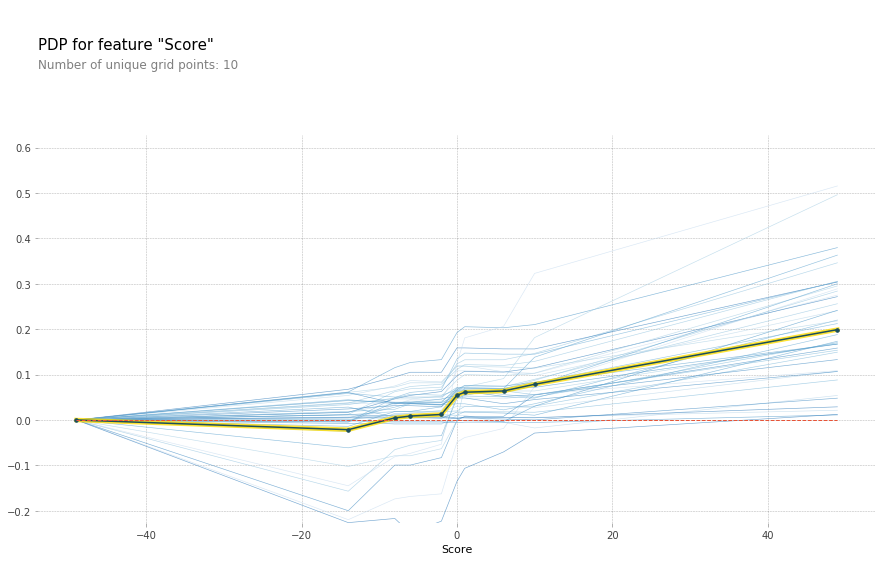

In [71]:
pdp_plot(isolated, feature_name='Score', plot_lines=True, frac_to_plot=40)


In [0]:
# making another isolate and then comparing as it changes
second_isolated = pdp_isolate(theXGB, x_train_w_featImp, x_train_w_featImp.columns, 
                              feature='YardLine' )

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b2347d68>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b2542438>})

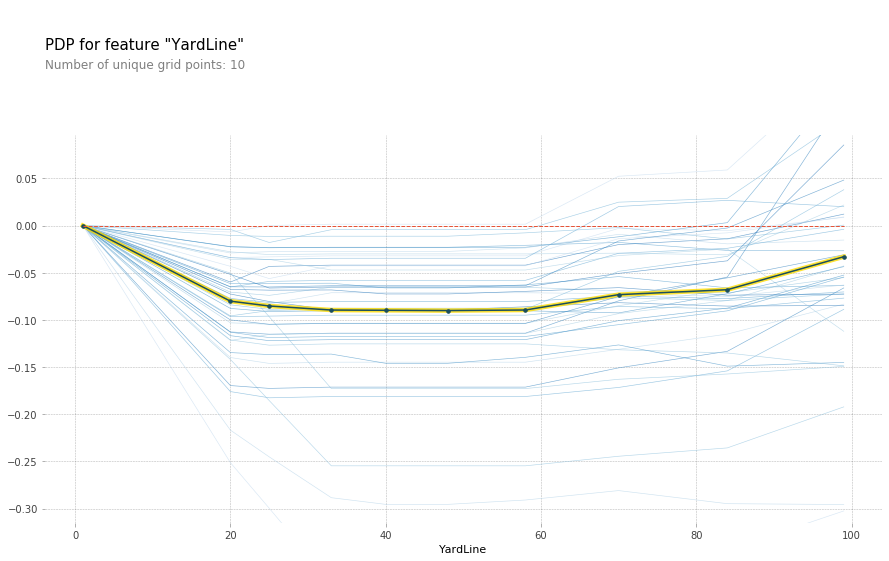

In [73]:
# Doing the second plot
pdp_plot(second_isolated, feature_name='YardLine', plot_lines=True,
         frac_to_plot=40)

In [0]:
# Doing the third plot of a partial plot
third_isolate = pdp_isolate(theXGB, x_train_w_featImp, x_train_w_featImp.columns, 
                            feature='SecondsLeftInGame')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b21ff240>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b23efa58>})

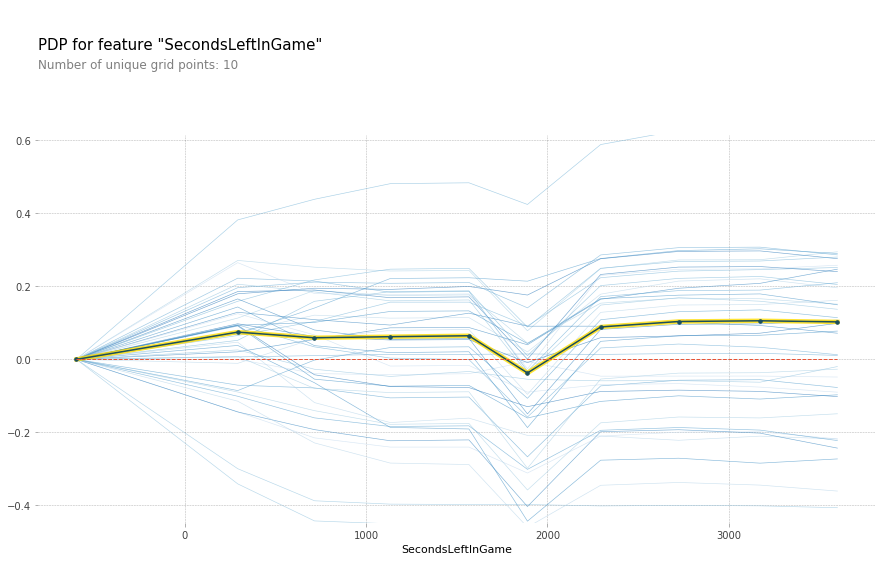

In [75]:
pdp_plot(third_isolate, feature_name='SecondsLeftInGame', plot_lines=True, 
         frac_to_plot=40)

In [0]:
theFeatures = ['Formation_NO HUDDLE SHOTGUN','Formation_UNDER CENTER', 
               'Formation_SHOTGUN', 'Formation_NO HUDDLE']

In [0]:
# Doing one last plot that is with several variables
fourth_isolate = pdp_isolate(theXGB, x_train_w_featImp, x_train_w_featImp.columns, feature=theFeatures)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b2261940>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f08b2319fd0>})

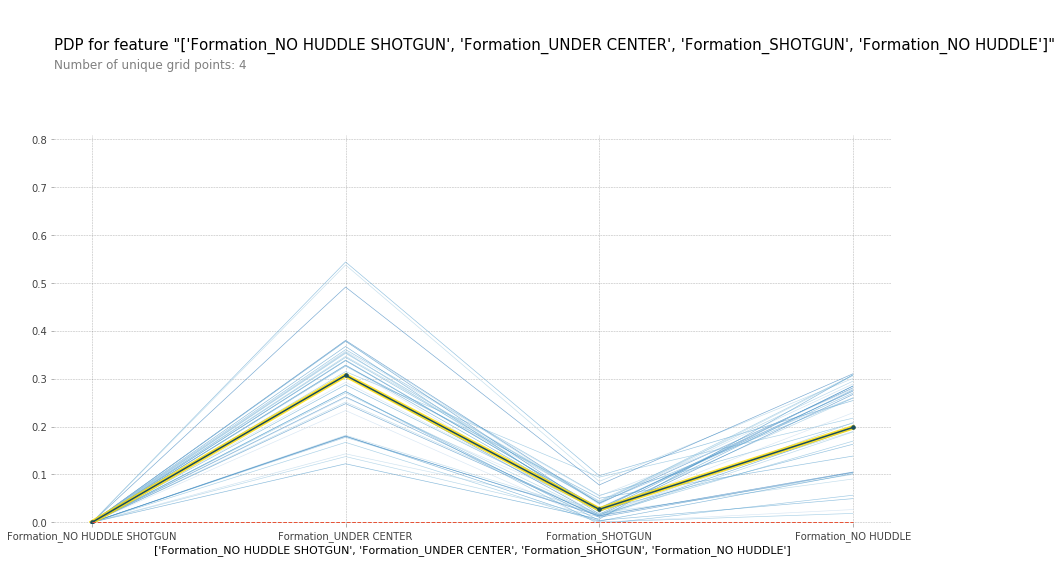

In [78]:
# Doing the plot:
pdp_plot(fourth_isolate, theFeatures, plot_lines=True, frac_to_plot=40)

In [0]:
# Doing a shapley type for one of the rows 
explainer = shap.TreeExplainer(theXGB)

In [95]:
# Picking our a row where the playType is a "Pass"
y_train.iloc[150] == "Rush"
# The values for the y are Rush or Pass

True

In [92]:
y_train.iloc[80] == 'Pass'

True

In [0]:
# Getting a Row that has a rush
rushRow = x_train_w_featImp.iloc[[150]] # With the double bracket it still is a dataFrame
passRow = x_train_w_featImp.iloc[[80]]
# Pulling out the y values for the rush and the run
y_rush = y_train.iloc[150]
y_pass = y_train.iloc[80]
                                 

In [0]:
rush_shap_vals = explainer.shap_values(rushRow, y=None )
pass_shap_vals = explainer.shap_values(passRow, y=None)

In [104]:
# Doing the force plot
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=rush_shap_vals, features=rushRow,
                )

In [107]:
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=pass_shap_vals, features=passRow, )

[<matplotlib.lines.Line2D at 0x7f08b4d60358>]

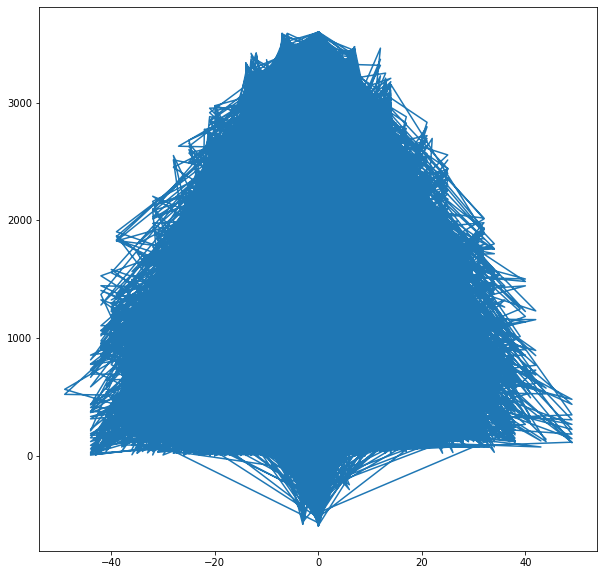

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_train_w_featImp['Score'], x_train_w_featImp['SecondsLeftInGame'])


In [0]:
# Seeing what is in the df that has down to be o
theset = set()
theList = []
for i in range(len(games)):
  t = games[i][games[i]['ToGo'] == 0]
  if len(t.index) > 0:
    theList.append(t)
  #theset.update(t["PlayType"].value_counts().index.to_list())
len(theList)
theList[2]['Description'].to_list()
theList[2].head()

,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play
20811,2017-12-03,3,KC,NYJ,0,0,35,1,7-H.BUTKER KICKS 65 YARDS FROM KC 35 TO NYJ 0....,0,UNDER CENTER,PASS,0,0,NaN,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NONE,0,1800,-4,Pass,14,Rush


In [0]:
t = df18[df18['ToGo'] == 0]
t.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
16,2018123015,2018-12-30,3,0,11,ARI,SEA,0,0,98,NaN,1,NaN,0,TWO-POINT CONVERSION ATTEMPT. 31-D.JOHNSON RUS...,0,NaN,NaN,2018,0,UNDER CENTER,TWO-POINT CONVERSION,0,0,0,0,NaN,0,0,0,NaN,0,0,0,0,1,1,NaN,2,OPP,0,NaN,0,NaN,0
17,2018123015,2018-12-30,3,4,34,SEA,ARI,0,0,85,NaN,1,NaN,0,"11-S.JANIKOWSKI EXTRA POINT IS GOOD, CENTER-69...",0,NaN,NaN,2018,0,UNDER CENTER,EXTRA POINT,0,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,NaN,15,OPP,0,NaN,0,NaN,0
29,2018123015,2018-12-30,2,5,44,ARI,SEA,0,0,85,NaN,1,NaN,0,"5-Z.GONZALEZ EXTRA POINT IS GOOD, CENTER-46-A....",0,NaN,NaN,2018,0,UNDER CENTER,EXTRA POINT,0,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,NaN,15,OPP,0,NaN,0,NaN,0
33,2018123015,2018-12-30,2,11,39,SEA,ARI,0,0,85,NaN,1,NaN,0,"11-S.JANIKOWSKI EXTRA POINT IS GOOD, CENTER-69...",0,NaN,NaN,2018,0,UNDER CENTER,EXTRA POINT,0,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,NaN,15,OPP,0,NaN,0,NaN,0
39,2018123015,2018-12-30,1,1,25,SEA,ARI,0,0,85,NaN,1,NaN,0,"11-S.JANIKOWSKI EXTRA POINT IS GOOD, CENTER-69...",0,NaN,NaN,2018,0,UNDER CENTER,EXTRA POINT,0,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,NaN,15,OPP,0,NaN,0,NaN,0


In [0]:
games[1].head(3)

,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play
17317,2018-12-30,1,SEA,ARI,1,10,19,0,(13:28) (SHOTGUN) 53-J.HUNT REPORTED IN AS ELI...,5,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,0,NaN,0,NaN,0,3508,0,Rush,0,No Previous
17316,2018-12-30,1,SEA,ARI,2,5,24,1,(12:57) (SHOTGUN) 32-C.CARSON RIGHT TACKLE TO ...,8,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,RIGHT TACKLE,0,NaN,0,NaN,0,3477,0,Rush,5,Rush
17315,2018-12-30,1,SEA,ARI,1,10,32,0,(12:21) (SHOTGUN) 27-M.DAVIS UP THE MIDDLE TO ...,3,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,0,NaN,0,NaN,0,3441,0,Rush,8,Rush


In [0]:
theList = [0, 2]

def addToList(number, thelist):
  theList.append(number)
  return theList
def changeList(someList):
  someList.append(2)
  someList = addToList(3, someList)
  return someList
theList = changeList(theList)
theList

[0, 2, 2, 3]

In [0]:
import ipdb

In [0]:
# creating the function that will categorize
# how succesfull a play is.
# Folowing what was determined by 
# Bob Carroll and Pete Palmer and John Thorn, in their
# book called "The Hidden Game of Football".
# Also using a method similar to those on Footballoutsiders.com

# First Down play need --- 45% of required yards (yards for first down)to get a point
# Second Down play needs-- 60% of required yards (yards for first down)
# Third and Forth need 100 % of required yards to first down to be succes

def getPercentage(down, distance):
  
  if down == 4 or down == 3:
    return distance
  if down == 2:
    return distance * .6
  if down == 1:
    return distance * .45

# This is an inner method that will load the 
# categories with the score
# I am using this method instead of a pandas cut 
# because I already am looping through
# the dataframe to get the score so at the
# same time will make the categories
def fillOtherCat(numberToSkip, catList):
  for i in range(len(catList)):
    if numberToSkip != i:
      catList[i].append(0)
  return catList

def loadCategories(catList, score, theBins):

  # will only loop to be able to put in each category
  for i in range(len(theBins)):
    # if the score is greater than upper bin
    # the the score must be placed in a lower bin
    if score < theBins[i]:
      catList[i].append(1)
      catList = fillOtherCat(i, catList)
      return  catList


# Succesfull play == 1 point 
# Unsuccesfull play = 0 points
# Fractional points for can by if yards are gained but not the complete
# required for the down
# First Fractional (yardsGained/YardsNeededFor45%ToFirstDown - ( .1)
# Second Fraction  (yardsGained/YardsNededFor60%ToFirstDown) -(.2)
# Third Fraction (yardsGained/YardsNeededToFirstDown) - .3
# Fourth Fraction --No Fraction if not succesfull

# Fumble == minus 2
# Interception == minus 4
# loss of 3 yards or more minus 1 point

# Got a TouchDown plus  1 point 
# Gained 15 yards 1 point
# If got a first down on a fourth down get an extra point

# Categories:
# High Success = 2 points
# Sucessfull = 1 points up to 2
# SomeWhatSucessfull =  .5 to.99
# MildlySuccesfull = greater than .25 to less than .50
# VeryLittleSucess = greater then .20 to .25
# Unsuccesfull = 0 points to .19
# BadPlay = less than 0



def createSuccesCategories(df,  asScore=False , addCatAsColumns=True):
  ''' Method to make the categories for the type of previous play

      df: The dataframe that to be worked on.

      asScore:  Default is False.  When true will cause the scores used to 
                bin the previous plays to be returned as a list.

      addCatAsColumns:  Default is True. When True it will cause the categories
                        to be added to the dataFrame and then the whole dataFrame is 
                        returned. When false will return a list that contains the categories
                        The first category is the worst and progressively getting better
                        and better to the end of the category list.
      
      Returns:    Will return list of Scores is asScore is True.  Will return list of 
                  categorieys if addCatAsColumns is False.  Otherwise will return the new
                  dataframe with the categories added to it.
                  '''
                 
  # Creating the lists that will make the categories 
  highSuccess = []
  success = []
  somewhat = []
  mildSuccess = []
  littleSuccess = []
  unsucces = []
  bad = []

  # This is the default score for the first play
  defaultScore = .65
  playQuality = [defaultScore] # This is appended because we are looking at
                      # the previous play.  The first play recieves this
                      # score for a pretend previou play neither success nor
                      # to much success.  
  score = 0
  theScore = 0
  bins = [0, .20, .26, .51, 1.0, 2, 99]

  catNames =   [ 'prev_ply_bad','prev_ply_no_succ', 'prev_ply_little_succ',
              'prev_ply_mild_succ', 'prev_ply_somewhat_succ', 'prev_ply_succ',
              'prev_ply_high_succ'
              ]

  # Loading all the categories into a list
  # A list of lists
  theCats = [highSuccess, success, somewhat, 
        mildSuccess, littleSuccess, unsucces, bad ]
    # will cycle through the whole data frame
    # except for the last play becuase this has
    # no play after it.

    # Loading the default score
  theCats = loadCategories(theCats, defaultScore, bins )
  for i in range(len(df)-1):
    score = 0
    row = df.iloc[i]
    down = df.iloc[i]['Down']
    
    if row['IsTwoPointConversion'] == 1:
      down = 4

    percentage = getPercentage(down, df.iloc[i]['ToGo'])

    theScore = (df.iloc[i]['Yards']/ percentage)
    if theScore >= 1:
      score = 1
      if down == 4:
        score += 1
    else:
      score = theScore - (down/10)
    
    if row['IsInterception'] == 1:
      score = score - 4
    if row['IsFumble'] == 1:
      score = score -2
    if row['Yards'] >= 15:
      score = score + 1
    if row['IsTouchdown'] == 1:
      score = score + 1
  # Build playQuality list
    playQuality.append(score)
    #catList, theScore, theBins
    theCats = loadCategories(theCats, score, bins )
  if  asScore== True:
    
    # This will not have the last score in it
    return playQuality
  else:
    # Returning the list of each category
    if addCatAsColumns:
      # Returning whole dataFrame with categoies added
      for i in range(len(catNames)):
        df[catNames[i]] = theCats[i]
      return df

  return theCats

In [0]:
theDf = createSuccesCategories(games[1] )
theDf.sample(3)

,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play,prev_ply_bad,prev_ply_no_succ,prev_ply_little_succ,prev_ply_mild_succ,prev_ply_somewhat_succ,prev_ply_succ,prev_ply_high_succ
2,2018-12-30,4,SEA,ARI,2,8,77,1,(:16) 53-J.HUNT REPORTED IN AS ELIGIBLE. 32-C...,11,UNDER CENTER,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,RIGHT END,0,NaN,0,NaN,0,16,0,Rush,2,Rush,0,0,0,1,0,0,0
14,2018-12-30,4,SEA,ARI,2,12,67,1,(8:17) (SHOTGUN) 3-R.WILSON PASS SHORT RIGHT T...,12,SHOTGUN,PASS,0,0,SHORT RIGHT,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,497,0,Pass,-2,Rush,1,0,0,0,0,0,0
19,2018-12-30,3,SEA,ARI,1,10,72,1,(5:19) (SHOTGUN) 3-R.WILSON PASS SHORT RIGHT T...,11,SHOTGUN,PASS,0,0,SHORT RIGHT,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,1219,1,Pass,61,Rush,0,0,0,0,0,0,1


In [0]:
len(games[1])

60

In [0]:
games[1].head(4)

,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play
17317,2018-12-30,1,SEA,ARI,1,10,19,0,(13:28) (SHOTGUN) 53-J.HUNT REPORTED IN AS ELI...,5,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,0,NaN,0,NaN,0,3508,0,Rush,0,No Previous
17316,2018-12-30,1,SEA,ARI,2,5,24,1,(12:57) (SHOTGUN) 32-C.CARSON RIGHT TACKLE TO ...,8,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,RIGHT TACKLE,0,NaN,0,NaN,0,3477,0,Rush,5,Rush
17315,2018-12-30,1,SEA,ARI,1,10,32,0,(12:21) (SHOTGUN) 27-M.DAVIS UP THE MIDDLE TO ...,3,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,0,NaN,0,NaN,0,3441,0,Rush,8,Rush
17314,2018-12-30,1,SEA,ARI,2,7,35,0,(11:43) 3-R.WILSON PASS INCOMPLETE DEEP RIGHT.,0,UNDER CENTER,PASS,1,0,DEEP RIGHT,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,3403,0,Pass,3,Rush


In [0]:
games[1].iloc[3:].head(4)

,GameDate,Quarter,OffenseTeam,DefenseTeam,YardLine,SeriesFirstDown,Description,Formation,PlayType,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play,first_to_go,second_to_go,third_to_go,fourth_to_go,two_point_to_go
17314,2018-12-30,1,SEA,ARI,35,0,(11:43) 3-R.WILSON PASS INCOMPLETE DEEP RIGHT.,UNDER CENTER,PASS,1,0,DEEP RIGHT,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,3403,0,Pass,3,Rush,0,7,0,0,0
17313,2018-12-30,1,SEA,ARI,35,1,(11:36) (SHOTGUN) 84-E.DICKSON LEFT END TO SEA...,SHOTGUN,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,LEFT END,0,NaN,0,NaN,0,3396,0,Rush,0,Pass,0,0,7,0,0
17312,2018-12-30,1,SEA,ARI,44,0,(11:01) 3-R.WILSON PASS SHORT RIGHT TO 18-J.BR...,UNDER CENTER,PASS,0,0,SHORT RIGHT,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,3361,0,Pass,9,Rush,10,0,0,0,0
54,2018-12-30,1,SEA,ARI,51,0,(10:32) 32-C.CARSON LEFT END TO ARI 49 FOR NO ...,UNDER CENTER,RUSH,0,0,NaN,0,0,0,0,0,0,0,0,LEFT END,0,NaN,0,NaN,0,3332,0,Rush,7,Pass,0,3,0,0,0


In [0]:
# Making the function that will take in a list of games and then

In [0]:
# Separating the each game by the teams when on offense and then reordering
# with the secondsTillgame column.
# This method will return a list that has 
# the games divided by each team
def separateByTeam(games):
  firstTeam = ''
  secondTeam = ''
  newGamesList = []
  for game in games:
    firstTeam = game.iloc[0]['OffenseTeam']
    for i in range(len(game)):
      if game.iloc[i]["OffenseTeam"] != firstTeam:
        secondTeam = game.iloc[i]["OffenseTeam"]
        break
    # Separating each game by each team when they are
    # on offense
    first = game[game['OffenseTeam'] == firstTeam]
    second = game[game['OffenseTeam'] == secondTeam]
    newGamesList.append(first)
    newGamesList.append(second) 
  # returning the list that contains the games broken down by team 
  # when they are on offense
  return newGamesList  


In [0]:
# We will now make the target feature
# I want a name and not one or zero or True or False
def makeTarget(df):
  mask = (df['IsRush'] == 1)
  theList = []
  for i in range(len(df)):
    if mask.iloc[i] == 1:
      theList.append('Rush')
    else:
      theList.append('Pass')
      
  df['Play'] = theList
  
   
  return df


In [0]:
games[1].head(4)

,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play
17317,2018-12-30,1,SEA,ARI,1,10,19,0,(13:28) (SHOTGUN) 53-J.HUNT REPORTED IN AS ELI...,5,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,19,OWN,0,NaN,0,NaN,0,3508,0,Rush
17316,2018-12-30,1,SEA,ARI,2,5,24,1,(12:57) (SHOTGUN) 32-C.CARSON RIGHT TACKLE TO ...,8,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,RIGHT TACKLE,24,OWN,0,NaN,0,NaN,0,3477,0,Rush
17315,2018-12-30,1,SEA,ARI,1,10,32,0,(12:21) (SHOTGUN) 27-M.DAVIS UP THE MIDDLE TO ...,3,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,32,OWN,0,NaN,0,NaN,0,3441,0,Rush
17314,2018-12-30,1,SEA,ARI,2,7,35,0,(11:43) 3-R.WILSON PASS INCOMPLETE DEEP RIGHT.,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,3403,0,Pass


In [0]:
# making columns for each down
# Trying to see if this will make model see the importance of the down that it is on
# This method will drop the toGo and the down features
def makeDownCols(df):
  first = []
  second = []
  thid = []
  fourth = []
  twoPoint = []
  for i in range(len(df)):
    if df.iloc['Down'] == 1:
      first.append(df.iloc[i]['ToGo'])
      second.append(0)
      third.append(0)
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc['Down'] == 2:
      first.append(0)
      second.append(df.iloc[i]['ToGo'])
      third.append(0)
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc['Down'] == 3:
      first.append(0)
      second.append(0)
      third.append(df.iloc[i]['ToGo'])
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc['Down'] == 4:
      first.append(0)
      second.append(0)
      third.append(0)
      fourth.append(df.iloc[i]['ToGo'])
      twoPoint.append(0)
    elif df.iloc['Down'] == 0:
      first.append(0)
      second.append(0)
      third.append(0)
      fourth.append(0)
      twoPoint.append(df.iloc[i]['ToGo'])
      
  # Dropping the columns down and togo
  df = df.drop(labels=['Down', 'ToGo'], axis=1)
    
  return df

In [0]:
# moving the yards gained on last offensive play
theCopy = games[1].copy()
playPrev = theCopy['Play'].to_list()
playPrev.pop()
ply = ["No Previous"]
playPrev = ply + playPrev
theCopy['prev_offense_play'] = playPrev
theCopy.head()


,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame,Score,Play,prev_offense_play
17317,2018-12-30,1,SEA,ARI,1,10,19,0,(13:28) (SHOTGUN) 53-J.HUNT REPORTED IN AS ELI...,5,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,19,OWN,0,NaN,0,NaN,0,3508,0,Rush,No Previous
17316,2018-12-30,1,SEA,ARI,2,5,24,1,(12:57) (SHOTGUN) 32-C.CARSON RIGHT TACKLE TO ...,8,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,RIGHT TACKLE,24,OWN,0,NaN,0,NaN,0,3477,0,Rush,Rush
17315,2018-12-30,1,SEA,ARI,1,10,32,0,(12:21) (SHOTGUN) 27-M.DAVIS UP THE MIDDLE TO ...,3,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,32,OWN,0,NaN,0,NaN,0,3441,0,Rush,Rush
17314,2018-12-30,1,SEA,ARI,2,7,35,0,(11:43) 3-R.WILSON PASS INCOMPLETE DEEP RIGHT.,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,3403,0,Pass,Rush
17313,2018-12-30,1,SEA,ARI,3,7,35,1,(11:36) (SHOTGUN) 84-E.DICKSON LEFT END TO SEA...,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,LEFT END,35,OWN,0,NaN,0,NaN,0,3396,0,Rush,Pass


In [0]:
games[3]['PlayType'].value_counts()

PASS                    80
RUSH                    43
TWO-POINT CONVERSION     2
SCRAMBLE                 2
SACK                     2
Name: PlayType, dtype: int64

In [0]:
# When the PlayType is a sack or a scramble, I 
# will make the column that says Pass to be 1.
# This is because the great majority of sacks and scrambles occur
# on pass plays where the quarterback can't find anyone open.
for game in games:
  mask = (df17['PlayType'] == 'SACK') | (df17['PlayType'] == 'SCRAMBLE')
  mask
  df17.loc[mask, 'IsPass'] = 1
  df17.loc[mask, 'IsRush'] = 0
  df17[mask].head()
#df17[mask].iloc[:4]['Description'].to_list()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
80,2017091711,2017-09-17,2,8,16,WAS,LA,2,8,38,NaN,0,NaN,0,(8:16) 8-K.COUSINS SACKED AT WAS 26 FOR -12 YA...,0,NaN,NaN,2017,-12,UNDER CENTER,SACK,0,1,0,0,NaN,1,0,0,NaN,0,0,0,0,0,0,NaN,38,OWN,0,NaN,0,NaN,0
112,2017092408,2017-09-24,2,4,55,NYJ,MIA,3,7,27,NaN,0,NaN,0,(4:55) (SHOTGUN) 15-J.MCCOWN SCRAMBLES RIGHT E...,0,NaN,NaN,2017,1,SHOTGUN,SCRAMBLE,0,1,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,NaN,27,OWN,0,NaN,0,NaN,0
118,2017092500,2017-09-25,2,14,52,ARI,DAL,3,15,80,NaN,0,NaN,0,(14:52) (SHOTGUN) 3-C.PALMER SCRAMBLES UP THE ...,0,NaN,NaN,2017,2,SHOTGUN,SCRAMBLE,0,1,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,NaN,20,OPP,0,NaN,0,NaN,0
130,2017100103,2017-10-01,2,12,33,CLE,CIN,2,6,50,NaN,0,NaN,0,(12:33) (SHOTGUN) 7-D.KIZER SACKED AT CLE 43 F...,0,NaN,NaN,2017,-7,SHOTGUN,SACK,0,1,0,0,NaN,1,0,0,NaN,0,0,0,0,0,0,NaN,50,OPP,0,NaN,0,NaN,0
131,2017100103,2017-10-01,2,6,53,CIN,CLE,1,10,32,NaN,0,NaN,0,(6:53) (SHOTGUN) 14-A.DALTON SACKED AT CIN 25 ...,0,NaN,NaN,2017,-7,SHOTGUN,SACK,0,1,0,0,NaN,1,0,0,NaN,0,0,0,0,0,0,NaN,32,OWN,0,NaN,0,NaN,0


In [0]:
len(games)

254

In [0]:
# Finding out the types of playTypes there are in the dataSet
theSet = set()
for i in range(len(games)):
  r = games[i]['PlayType'].value_counts().index.to_list()
  theSet.update(r)
theSet

{'EXCEPTION', 'PASS', 'RUSH', 'SACK', 'SCRAMBLE', 'TWO-POINT CONVERSION'}

In [0]:
  # Will remove the rows that have the "QB KNEEL", 'EXTRA POINT' , "CLOCK STOP", 
#'KICK OFF',  'FIELD GOAL', "PUNT", 'FUMBLES', in the PlayType column
# This is to make it so that we are really looking at plays that are pass and run plays

for i in range(len(games)):
  # getting the mask
  m = ((games[i]['PlayType'] == 'KICK OFF') | (games[i]['PlayType'] == 'FIELD GOAL') |
       (games[i]["PlayType"] == "PUNT") |  (games[i]["PlayType"] == "FUMBLES") |
       (games[i]["PlayType"] == "QB KNEEL") | (games[i]["PlayType"] == "EXTRA POINT")  |
       (games[i]["PlayType"] == "CLOCK STOP"))
  
  theIndex = games[i][m].index.to_list()
  games[i] = games[i].drop(theIndex , axis=0)


In [0]:
games[1]["PlayType"].value_counts()

PASS                    61
RUSH                    59
SACK                     3
EXCEPTION                1
TWO-POINT CONVERSION     1
Name: PlayType, dtype: int64

In [0]:
# grabbing all the Exceptions from the game list
listofRows = []
for i in range(len(listOfGames)):
  mask = (listOfGames[i]["Description"].str.contains("END OF QUARTER")) | (listOfGames[i]['Description'].str.contains('END OF GAME'))
  if len(listOfGames[i][mask]) < 0:
    listofRows.append(listOfGames[i][mask])
  
listofRows

[]

In [0]:
clock = df[df['PlayType'] == "PENALTY"] # Will drop the plays where the play type is a fumble
clock.head(3)
clock['Description'].to_list()
#clock.head(4)
#t = clock[clock['OffenseTeam'] =='BAL']
#t.head(10)
#len(clock)


['(3:04) (SHOTGUN) PENALTY ON GB, DELAY OF GAME, DECLINED.',
 '(1:08) (RUN FORMATION) PENALTY ON DEN, DELAY OF GAME, DECLINED.']

In [0]:
clock = df[df['PlayType'] == "PENALTY"]
clock.head(4)
#clock['Description'].to_list()
#len(clock)

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
12173,2019092907,2019-09-29,2,13,15,NYG,WAS,2,3,75,NaN,0,NaN,0,(13:15) (SHOTGUN) 22-W.GALLMAN JR RIGHT END PU...,0,NaN,NaN,2019,0,SHOTGUN,PENALTY,0,0,0,0,NaN,0,0,0,NaN,0,0,0,1,0,0,NaN,25,OPP,1,WAS,0,FACE MASK (15 YARDS),2
12598,2019092906,2019-09-29,1,12,18,LAC,MIA,1,10,73,NaN,0,NaN,0,(12:18) DIRECT SNAP TO 5-T.TAYLOR. 5-T.TAYLOR...,0,NaN,NaN,2019,0,UNDER CENTER,PENALTY,0,0,0,0,NaN,0,0,0,NaN,0,0,0,1,0,0,NaN,27,OPP,1,LAC,0,OFFENSIVE HOLDING,10
14042,2019091600,2019-09-16,3,11,17,CLE,NYJ,4,4,51,NaN,0,NaN,0,"(11:17) (PASS FORMATION) PENALTY ON CLE, DELAY...",0,NaN,NaN,2019,0,UNDER CENTER,PENALTY,0,0,0,0,NaN,0,0,0,NaN,0,0,0,1,0,0,NaN,49,OPP,0,CLE,0,DELAY OF GAME,0
14051,2019091600,2019-09-16,2,1,3,CLE,NYJ,4,4,50,NaN,0,NaN,0,"(1:03) (SHOTGUN) PENALTY ON CLE, DELAY OF GAME...",0,NaN,NaN,2019,0,SHOTGUN,PENALTY,0,0,0,0,NaN,0,0,0,NaN,0,0,0,1,0,0,NaN,50,OPP,0,CLE,0,DELAY OF GAME,0


In [0]:
# Want to look at the play types to see what the value_counts
#theList =listOfGames[0]['Description'].value_counts(dropna=False).index.to_list()
#theList

In [0]:
# Function to see it is a really a score
def isScore(df, currentIndex, team):
  # checking if next play is a extra point 
  # or two point conversion try
  nextPlay = df.iloc[currentIndex + 1]
  if nextPlay['PlayType'] == 'EXTRA POINT' or nextPlay['PlayType'] == 'TWO-POINT CONVERSION':
    if nextPlay['OffenseTeam'] != team:
      return True , nextPlay['OffenseTeam']
    else:
      return True , team
  return False , team

In [0]:
count = 0
# Checking to see if any of the nullified touchdowns are left
for game in listOfGames:
  penalty = game[game['IsPenalty'] == 1]
  penaltyTouch = penalty[penalty['IsTouchdown'] == 1]
  nulled = penaltyTouch[penaltyTouch['Description'].str.contains('TOUCHDOWN NULLIFIED')]
  # counting the number to be touchdown
  for i in range(len(nulled)):
    row = nulled.iloc[i]
    if i < len(nulled) -1:
      thebool , theTeam = isScore(nulled, i, row['OffenseTeam']) 
      if thebool:
        count += len(nulled)
count

0

In [0]:
for game in listOfGames:
  touchDown = game[game['IsTouchdown'] == 1]
  count  += len(touchDown)
count

1609

In [0]:
# Checking to see if they get an interception and then run it back for a touchDown
theCount = 0

# Looping through the rows
for i in range(len(interception)):
  row = interception.iloc[i]
  if row['IsTouchdown'] == 1:
    theCount += 1
theCount    

33

In [0]:
# Want to see the number times that the field goal was blocked and then ran for a touchdown
isTouch = df[df['PlayType'] == 'FIELD GOAL']
theTouch = isTouch[isTouch['IsTouchdown'] == 1]
len(theTouch)

1

In [0]:
len(listOfGames[1][t])

In [0]:
!pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.12.3-cp36-none-any.whl size=9225 sha256=08e969409af57511da31318021b8a4e65b5cb9083936f3647a62a9acd5ca98ee
  Stored in directory: /root/.cache/pip/wheels/57/43/c5/614153606de8f5e358e266723f53254e70752f4ffc8c85ec63
Successfully built ipdb


In [0]:
import ipdb

In [0]:
theAns = 12 == 14
theAns

False

In [0]:
# making the score

# Function for checking if there is a touchDown
# It will return a number if there really was no touchdown
# If there is a touchdown then it will return the team who scored the touchdown

def whoScored(df, i, row_description):
  theCounter = i+1
  numberOfSearches = 1
  secondaryCount = i +1
  playReversed = row_description.rfind("PLAY WAS REVERSED")
  touchDown = row_description.rfind('TOUCHDOWN')
  time_touchdown_occured = df.iloc[i]['SecondsLeftInGame']
  extraPointTime = 0
  # Looking at the end of the game or the the end of the half
  endHalf = time_touchdown_occured < 1800 and time_touchdown_occured > 179
  if i >= len(df) -3:
    for j in range(i, len(df)):
      if (df.iloc[j]['PlayType'] == 'KICK OFF' or df.iloc[j]['IsTwoPointConversion'] == 1 
          or df.iloc[j]["PlayType"] == 'EXTRA POINT'):
        
        return df.iloc[j]['OffenseTeam']
    # if the following if statement is false that means that there was no 
    # touchdown. Some penalty caused it to be called back.
    if touchDown > playReversed:
      return df.iloc[i]['OffenseTeam']
    else:
      return theCounter
  # This means that the play was reversed
  if touchDown > playReversed:
    # If in here will be looking to see what team it is that has scored
    for num in range(i+1,i+4,1):
      # Adding this to stop from going out of the index
      if i == len(df)-4:
        num -=1
      #if numberOfSearches <= 3:
      if (df.iloc[num]['PlayType'] == 'EXTRA POINT' or df.iloc[num]['IsTwoPointConversion'] == 1): 
        # Setting the time that the extra point or two point conversion happened
        extraPointTime = df.iloc[num]['SecondsLeftInGame']
        # Choosing the stop point for the loop in searching for the
        # kickoff.  Making sure index isn't out of bounds
        stopPoint = i+10 if 10 < (len(df) - i) else len(df)
        for j in range(i+1, stopPoint, 1):
          #Now searching for a kickoff to see if they will match to
          #the Extra Point or two Point conversion 
          #Find the team that scored
          if df.iloc[j]['PlayType']  == "KICK OFF" and df.iloc[j]['SecondsLeftInGame'] == extraPointTime:
            return df.iloc[j]['OffenseTeam']
      # incrementing the counter
      theCounter +=1
      numberOfSearches +=1

  # Will check to see if the extra point and the kick off happened same time 
  # The time ordering can put it in front of the touchdown
  
    for j in range(i-1, i-3, -1):
      # This is a boolean to see if they occured the same time
      kick_or_two_point_time = time_touchdown_occured == df.iloc[j]['SecondsLeftInGame']
      if kick_or_two_point_time == True and df.iloc[j]['PlayType'] == "KICK OFF":
        return df.iloc[j]['OffenseTeam']
      elif kick_or_two_point_time == True and df.iloc[j]['PlayType'] == "EXTRA POINT":
        return df.iloc[j]['OffenseTeam']
      elif kick_or_two_point_time == True and df.iloc[j]['IsTwoPointConversion'] == 1:
        return df.iloc[j]['OffenseTeam']

      #df.iloc[secondaryCount]['PlayType'] == 'EXTRA POINT':
      #  secondaryCount +=1
      #  return df.iloc[i+1]["OffenseTeam"]
    
      
      # will return the counter if there was a penalty
  return theCounter
    


# This method will return a list that contains the scores
# in the football game but as one integer.
#  The number is representative of the offenseTeam.  0 means tie.
# 7 means the offense team is 7 points ahead.  -7 means the offense team is 
# 7 points behind.
def createScore(df):
  # This is the list that will keep the score 
  score = [0]
  # This the the first team
  trow = df.iloc[0]
  team = ''
  teamScored = ''
  newScore = 0

  for i in range(len(df)):
    # get the current team
    team = df.iloc[i]['OffenseTeam']

    if i == (len(df) -1):
      # Don't want to do anything to the score if it is the
      # last play of the game.
      #newScore = score[i]
      return score

    row = df.iloc[i]
    row_description = row['Description']
    nextPlay = df.iloc[i + 1]

    # TouchDown
    if row['IsTouchdown'] == 1:

      scoringTeam = whoScored(df, i, row_description)
      # This would mean that no one scored
      if isinstance(scoringTeam, int):
        if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
        else:
          newScore = score[i] + 0
      # Checking to see who scored the touchDown
      # making the score a negative
      elif team !=  nextPlay['OffenseTeam'] :
        if scoringTeam != team:
          newScore  = (score[i] - 6) * -1 
        else:
          newScore = ((score[i] + 6) *-1)
        
                   
      else:
    
        if scoringTeam != team:
          newScore = score[i] -6  
        else:       
          newScore = (score[i] + 6)
        
        
        # adding the new score to the list
      score.append(newScore)
       # Checking for an extra point   
    elif row['PlayType'] == "EXTRA POINT":
      
      if row_description.find('IS GOOD') != -1:
        if nextPlay['OffenseTeam'] != team:
          newScore = ((score[i] + 1) * - 1)
        else:
          newScore = score[i] + 1
          # if it was missed
      elif nextPlay['OffenseTeam'] != team:
        newScore = (score[i] * -1)
      else:
        newScore = score[i] + 0
      score.append(newScore)

    # Field Goals    
    elif  row['PlayType'] == 'FIELD GOAL':
      # This is the team that has kicked the field goal
      
      if row_description.find('IS GOOD') != -1:
        
        if nextPlay['OffenseTeam'] == team:
          newScore = score[i] + 3
        else:
          newScore = ((score[i] + 3) * -1)
      # if the field goal was missed and no TouchDown
      else:
        if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
        else:
          newScore = score[i] + 0
      score.append(newScore)
    # Doing two point conversions
    elif row['IsTwoPointConversion'] == 1:
      if row['IsTwoPointConversionSuccessful'] == 1:
        
        if nextPlay['OffenseTeam'] == team:
          newScore = (score[i] + 2)
        else:
          newScore = ((score[i] + 2) * -1)
          
      else:  # Tried the two Point conversion, not succesfull
        # will check to see if there was a defensive two point 
        # conversion
        two =  row_description.find('DEFENSIVE TWO-POINT ATTEMPT') 
        if two != -1 and two > row_description.find('ATTEMPT FAILS'):
          # defense scored
          if nextPlay['OffenseTeam'] == team:
            newScore = score[i] -2
          else:
            newScore = (score[i] -2) * -1
        elif nextPlay['OffenseTeam'] == team:
          newScore = score[i]
        else:
          newScore = (score[i] * -1)
      
       # Putting the newscore in the list 
      score.append(newScore)
      

    # Doing safties
    
    elif row_description.find('SAFETY') != -1:
      # Checking if the next play is a kickoff by same
      
      if nextPlay['OffenseTeam'] == team:
        # Using i - 2 because the team who is the offense has
        # not changed yet because they now have to kick the ball and are considered
        # offense still but the defense scored so it is negative
        newScore = score[i] - 2
      else:
        newScore = ((score[i] - 2) * -1)
      score.append(newScore)
    
    # Deciding what to do on all other plays
    else:
         
        # Other Team has the ball
      if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
      else:
        newScore = score[i]
      # appending the newScore
      score.append(newScore)

        

In [0]:
len(games)

255

In [0]:
games[100].iloc[22: ].head(5)
#games[151].iloc[-27:-23]['Description'].to_list()

,GameId,GameDate,Quarter,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,SecondsLeftInGame
6746,2018111500,2018-11-15,1,SEA,GB,2,12,79,0,(6:14) (SHOTGUN) 3-R.WILSON PASS INCOMPLETE DE...,0,SHOTGUN,PASS,0,1,1,0,DEEP MIDDLE,0,0,0,0,0,0,0,0,NaN,21,OPP,0,NaN,0,NaN,0,3074
6745,2018111500,2018-11-15,1,SEA,GB,3,12,79,0,(6:09) (SHOTGUN) 3-R.WILSON PASS INCOMPLETE DE...,0,SHOTGUN,PASS,0,1,1,0,DEEP LEFT,0,0,0,0,0,0,0,0,NaN,21,OPP,0,NaN,0,NaN,0,3069
6744,2018111500,2018-11-15,1,SEA,GB,4,12,79,0,(6:04) 11-S.JANIKOWSKI 39 YARD FIELD GOAL IS G...,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,0,0,0,0,0,NaN,21,OPP,0,NaN,0,NaN,0,3064
28208,2018111500,2018-11-15,1,SEA,GB,0,0,35,1,11-S.JANIKOWSKI KICKS 65 YARDS FROM SEA 35 TO ...,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,3060
28207,2018111500,2018-11-15,1,GB,SEA,1,10,25,1,(6:00) 12-A.RODGERS PASS SHORT LEFT TO 17-D.AD...,10,UNDER CENTER,PASS,0,1,0,0,SHORT LEFT,0,0,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0,3060


In [0]:
aList = createScore(games[100])
len(games[156])
len(aList)
#istOfGames[1]['Score'] = aList
#listOfGames[1].tail(5)
#listOfGames[0]['PlayType'].value_counts()
#listOfGames[1]['Score'].to_list()
#listOfGames[0].iloc[42:46].head(2)
#listOfGames[0].iloc[42]
aList


[0,
 0,
 0,
 0,
 0,
 6,
 -6,
 6,
 -7,
 -7,
 -7,
 7,
 7,
 7,
 7,
 7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -4,
 4,
 4,
 4,
 4,
 4,
 4,
 10,
 10,
 -11,
 -11,
 -11,
 -11,
 11,
 11,
 11,
 11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -11,
 -5,
 -4,
 4,
 4,
 4,
 4,
 4,
 4,
 -4,
 -4,
 -4,
 2,
 -3,
 3,
 -3,
 -3,
 -3,
 -3,
 3,
 4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 -4,
 -4,
 -4,
 -4,
 4,
 4,
 4,
 4,
 -4,
 -4,
 -4,
 -4,
 4,
 4,
 4,
 4,
 4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 -4,
 2,
 -3,
 3,
 -3,
 -3,
 -3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [0]:
def getScoresList(games):
  scores = 0
  theScores = []
  for i in range(len(games)):
    scores = createScore(games[i])
    if scores == -1:
      return i
    theScores.append(scores)
  return theScores  

In [0]:
r = getScoresList(games)

In [0]:
len(r)

255

In [0]:
t =df[(df['IsFumble'] == 1) | (df['IsInterception'] == 1)]
touch = t[t['IsTouchdown'] == 1]
touch.head(2)
touch.iloc[:2]['Description'].to_list()

['(8:39) 94-C.WILKINS REPORTED IN AS ELIGIBLE.  14-R.FITZPATRICK PASS SHORT RIGHT TO 94-C.WILKINS TO CIN 1 FOR NO GAIN (30-J.BATES III). FUMBLES (30-J.BATES III), AND RECOVERS AT CIN -3. TOUCHDOWN.',
 '(:23) (SHOTGUN) 17-P.RIVERS SACKED AT MIN 36 FOR -10 YARDS (99-D.HUNTER). FUMBLES (99-D.HUNTER) [99-D.HUNTER], TOUCHED AT MIN 38, RECOVERED BY MIN-95-I.ODENIGBO AT MIN 44. 95-I.ODENIGBO FOR 56 YARDS, TOUCHDOWN.']

PASS           88
RUSH           54
KICK OFF       16
FIELD GOAL      9
PUNT            8
SACK            5
EXTRA POINT     4
SCRAMBLE        3
QB KNEEL        3
FUMBLES         2
Name: PlayType, dtype: int64

In [0]:
t.iloc[:2]['Description'].to_list()

['(7:32) (SHOTGUN) 14-A.DALTON PASS SHORT RIGHT INTENDED FOR 83-T.BOYD INTERCEPTED BY 24-S.GILMORE AT NE 36. 24-S.GILMORE FOR 64 YARDS, TOUCHDOWN.',
 '(13:05) (SHOTGUN) 16-J.GOFF PASS SHORT RIGHT INTENDED FOR 17-R.WOODS INTERCEPTED BY 37-Q.DIGGS [49-SM.GRIFFIN] AT SEA 45. 37-Q.DIGGS FOR 55 YARDS, TOUCHDOWN.']

In [0]:
newDf = df[t]
newDf.head()
newDf['Description'].value_counts().index.to_list()

["(10:17) (SHOTGUN) 12-A.RODGERS FUMBLES (ABORTED) AT GB 42, RECOVERED BY MIN-51-H.MATA'AFA AT GB 42. 51-H.MATA'AFA TO GB 42 FOR NO GAIN (63-C.LINSLEY).",
 '(1:08) (SHOTGUN) 15-G.MINSHEW SACKED AT JAX 27 FOR -3 YARDS (26-P.WILLIAMS). FUMBLES (26-P.WILLIAMS) [26-P.WILLIAMS], RECOVERED BY JAX-27-L.FOURNETTE AT JAX 28. 27-L.FOURNETTE TO JAX 28 FOR NO GAIN (24-V.BELL). PENALTY ON NO-23-M.LATTIMORE, DEFENSIVE HOLDING, OFFSETTING, ENFORCED AT JAX 30 - NO PLAY. PENALTY ON JAX-68-A.NORWELL, OFFENSIVE HOLDING, OFFSETTING.',
 '(3:45) 22-W.GALLMAN JR RIGHT TACKLE TO NYG 38 FOR 2 YARDS (55-C.HOLCOMB). FUMBLES (55-C.HOLCOMB), RECOVERED BY WAS-96-T.HESTER AT NYG 37. 96-T.HESTER TO NYG 37 FOR NO GAIN (76-N.SOLDER). OFFICIALLY, A RUSH FOR 1 YARD.',
 '(10:22) (SHOTGUN) 16-J.GOFF PASS SHORT LEFT TO 18-C.KUPP TO LA 15 FOR NO GAIN (24-B.SKRINE). FUMBLES (24-B.SKRINE), RECOVERED BY LA-88-M.THOMAS AT LA 16. 88-M.THOMAS TO LA 16 FOR NO GAIN (95-R.ROBERTSON-HARRIS).',
 '(5:24) 26-A.PETERSON LEFT END TO GB 34 

In [0]:
fumbleTouchDown = newDf[(newDf['IsFumble'] == 1) & (newDf['IsTouchdown'] == 1)]

In [0]:
fumbleTouchDown['Description'].value_counts().index.to_list()

['(8:39) 94-C.WILKINS REPORTED IN AS ELIGIBLE.  14-R.FITZPATRICK PASS SHORT RIGHT TO 94-C.WILKINS TO CIN 1 FOR NO GAIN (30-J.BATES III). FUMBLES (30-J.BATES III), AND RECOVERS AT CIN -3. TOUCHDOWN.',
 '(:22) (SHOTGUN) 74-G.FANT REPORTED IN AS ELIGIBLE.  32-C.CARSON UP THE MIDDLE TO SEA 33 FOR 1 YARD (90-T.WATT). FUMBLES (90-T.WATT), RECOVERED BY PIT-26-M.BARRON AT SEA 34. 26-M.BARRON FOR 34 YARDS, TOUCHDOWN NULLIFIED BY PENALTY. PENALTY ON PIT-21-S.DAVIS, ILLEGAL BLOCK ABOVE THE WAIST, 10 YARDS, ENFORCED AT SEA 12.',
 '(3:49) (SHOTGUN) 6-B.MAYFIELD TO CLE 30 FOR -5 YARDS. FUMBLES, RECOVERED BY BUF-55-J.HUGHES AT CLE 30. 55-J.HUGHES FOR 30 YARDS, TOUCHDOWN. THE REPLAY OFFICIAL REVIEWED THE FUMBLE RULING, AND THE PLAY WAS REVERSED. (SHOTGUN) 6-B.MAYFIELD PASS INCOMPLETE SHORT MIDDLE TO 27-K.HUNT.',
 '(14:53) (SHOTGUN) 2-M.RUDOLPH ABORTED. 53-M.POUNCEY FUMBLES AT PIT 35, RECOVERED BY LA-56-D.FOWLER AT PIT 26. 56-D.FOWLER FOR 26 YARDS, TOUCHDOWN.',
 '(9:31) 33-K.JOHNSON UP THE MIDDLE TO KC

In [0]:
newDf.iloc[0]['Description']

'(11:33) (SHOTGUN) 10-M.TRUBISKY FUMBLES (ABORTED) AT CHI 43, RECOVERED BY CHI-17-A.MILLER AT CHI 40.'

In [0]:
t = listOfGames[1][(listOfGames[1]['Formation'] == 'SHOTGUN') & (listOfGames[1]['IsRush'] == 1)]

In [0]:
t.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,Description,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,Time
7,2019101400,2019-10-14,1,12,38,GB,DET,1,10,17,0,(12:38) (SHOTGUN) 33-A.JONES LEFT TACKLE TO GB...,2,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,LEFT TACKLE,17,OWN,0,NaN,0,NaN,0,12.38
15,2019101400,2019-10-14,1,8,31,DET,GB,1,3,97,0,(8:31) (SHOTGUN) 33-K.JOHNSON LEFT GUARD TO GB...,0,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,LEFT GUARD,3,OPP,0,NaN,0,NaN,0,8.31
27,2019101400,2019-10-14,1,2,53,DET,GB,2,9,33,1,(2:53) (SHOTGUN) 9-M.STAFFORD SCRAMBLES LEFT E...,10,SHOTGUN,SCRAMBLE,1,0,0,0,NaN,0,0,0,0,0,0,0,0,NaN,33,OWN,0,NaN,0,NaN,0,2.53
31,2019101400,2019-10-14,1,0,33,DET,GB,1,10,72,0,(:33) (SHOTGUN) 33-K.JOHNSON UP THE MIDDLE TO ...,0,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,CENTER,28,OPP,0,NaN,0,NaN,0,0.33
41,2019101400,2019-10-14,2,12,42,GB,DET,2,10,51,0,(12:42) (SHOTGUN) 33-A.JONES LEFT GUARD TO DET...,11,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,0,0,1,0,0,LEFT GUARD,49,OPP,1,GB,0,OFFENSIVE HOLDING,10,12.42


In [0]:
t.iloc[0]['Description']

'(12:38) (SHOTGUN) 33-A.JONES LEFT TACKLE TO GB 19 FOR 2 YARDS (98-D.HARRISON).'

In [0]:
j = pd.to_datetime(2019-12-29)

In [0]:
t = df[df['GameDate'] == j]

In [0]:
t.shape

(0, 37)

In [0]:
# Making the function that will find all the scores and then will place them on the play after
# So when a play is executing, we will know the score.
# The score will be a single number. 0 means tied.  positive 7 means the offense is 
# seven points ahead.  negative 7 means the defense is ahead by seven points

def makeTheScores(game):
  

SyntaxError: ignored

In [0]:
s = df[df["Down"] == 0]
s.head()